# House Price Prediction (Regression task)

Preprocessing steps:
- drop Id Column
- feature Engineering
- fill NA entries
- normalize positively skewed numerical data


# Exploring the Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm, skew
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, normalize, PowerTransformer

%matplotlib inline

In [2]:


df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')



0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64


<AxesSubplot:>

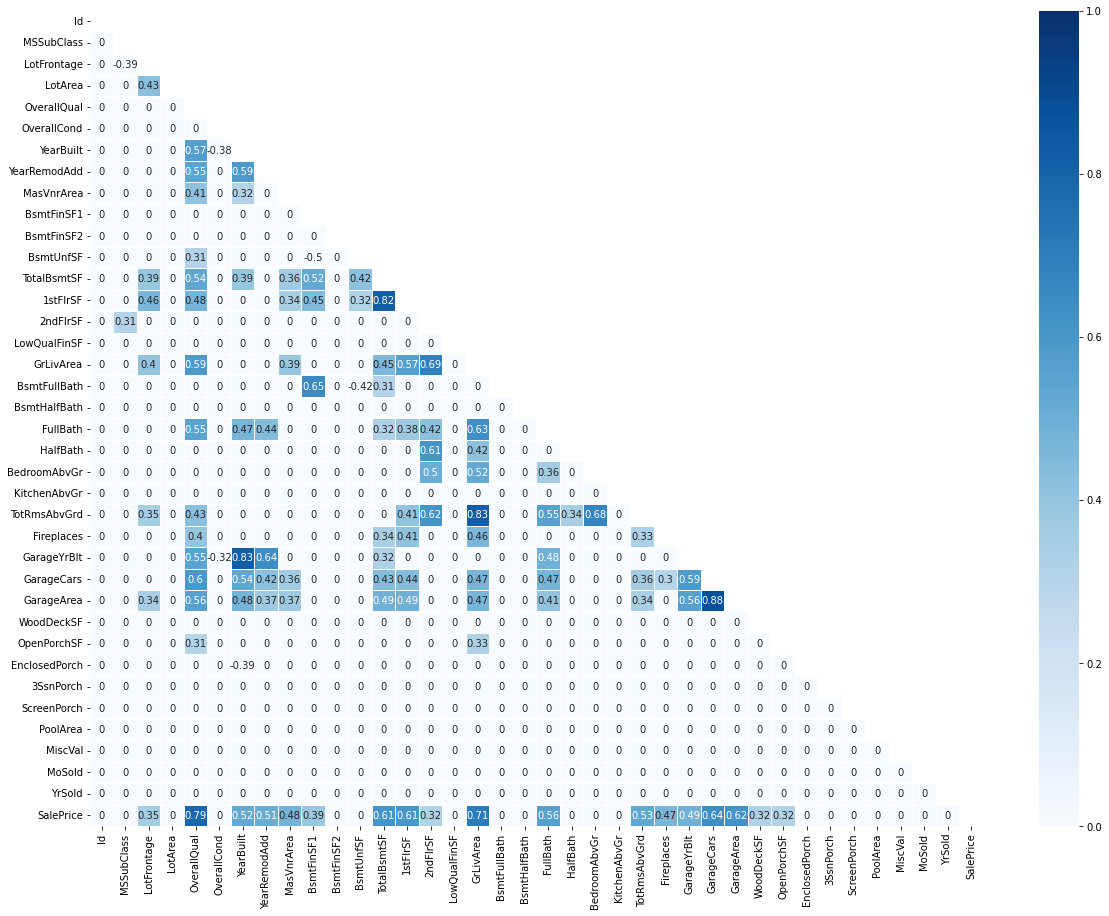

In [3]:
numerical_cols = [x for x in df.columns if df[x].dtype in('int64', 'float64')]
categorical_cols = [x for x in df.columns if df[x].dtype not in('int64', 'float64')]

df_numerical = df[numerical_cols]
plt.figure(figsize=(20,15))

correlation_mat = df_numerical.corr()
# drop Id
df.drop(['Id'], axis=1, inplace=True)
targets = np.log1p(df['SalePrice'])
df.drop(['SalePrice'], axis=1, inplace=True)
test_ids = df_test['Id']
df_test.drop(['Id'], axis=1, inplace=True)
print(test_ids)


mask = np.triu(np.ones_like(correlation_mat, dtype=bool))
correlation_mat[(correlation_mat < 0.3) & (correlation_mat > -0.3)] = 0
sns.heatmap(correlation_mat, annot=True, mask=mask, linewidth=0.5, cmap='Blues', vmin=0, vmax=1)

In [4]:
#create additional features
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']


#df['UnfinishedBsmntSFRatio'] = df['BsmtUnfSF'] / df['TotalBsmtSF']
#df_test['UnfinishedBsmntSFRatio'] = df_test['BsmtUnfSF'] / df_test['TotalBsmtSF']

df.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)
df_test.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

#df['BulidYear'] = np.sqrt((df['YearBuilt'] * df['YearRemodAdd']).to_numpy())
#df_test['BulidYear'] = np.sqrt((df_test['YearBuilt'] * df_test['YearRemodAdd']).to_numpy())

#df.drop(['YearBuilt', 'YearRemodAdd'], axis=1, inplace=True)
#df_test.drop(['YearBuilt', 'YearRemodAdd'], axis=1, inplace=True)

#df['AreaPerRoomAbvGrd'] = df['GrLivArea'] / df['TotRmsAbvGrd']
#df_test['AreaPerRoomAbvGrd'] = df_test['GrLivArea'] / df_test['TotRmsAbvGrd']

#df['BulidYear'] = np.sqrt((df['YearBuilt'] * df['YearRemodAdd']).to_numpy())
#df_test['BulidYear'] = np.sqrt((df_test['YearBuilt'] * df_test['YearRemodAdd']).to_numpy())



#df['Total_Home_Quality'] = df['OverallQual'] + df['OverallCond']
#df_test['Total_Home_Quality'] = df_test['OverallQual'] + df_test['OverallCond']


In [5]:
for col in df.isnull().keys():
    # fill with most common entry
    df[col]=df[col].fillna(df[col].mode()[0])
    
for col in df_test.isnull().keys():
    # fill with most common entry
    df_test[col]=df_test[col].fillna(df_test[col].mode()[0])  

In [6]:
# dummy variables from categorical features
df1 = df
df_test1 = df_test
train_test = pd.concat([df,df_test], axis=0, sort=False)
train_test.shape

(2919, 77)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


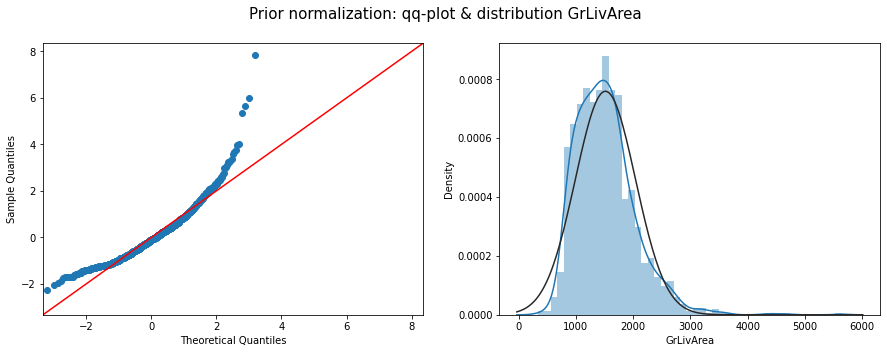

In [7]:
# GrLivArea before transformation

#in the right chart we can see that the data is squeezed to the left side -> this is called it is right skewed
# (or positively skewed, as the skew values are positive)

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle("Prior normalization: qq-plot & distribution GrLivArea ", fontsize= 15)

sm.qqplot(df1["GrLivArea"], stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])

sns.distplot(df1["GrLivArea"], kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

In [8]:
#get skewed features
numeric_features = train_test.dtypes[train_test.dtypes != object].index
skewed_features = train_test[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index
#normalize skewed features
for i in skew_index:
    train_test[i] = np.log1p(train_test[i])
#log1p = log(1 + x) -> we use this, as it is possible that we have 0 as a value -> log(0) not defined
# and log(1) = 0 so if x = 0, log(1 + x) results in 0


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


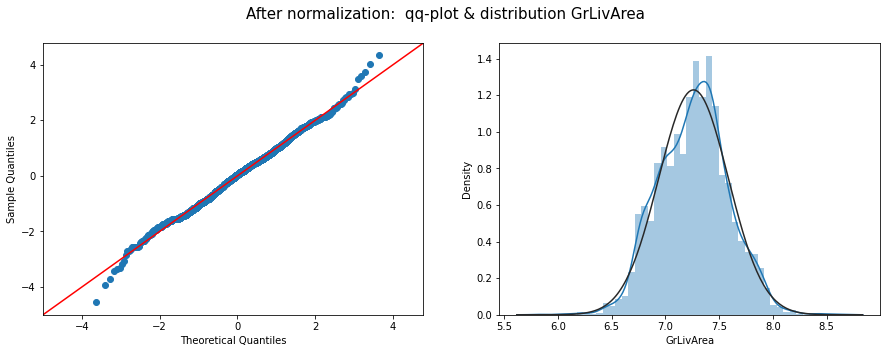

In [9]:
# GrLivArea after transformation

#after normalizing the data with the log we can see that the distribution now looks like a normal distribution and 
# the qq-plot supports that finding

fig, ax = plt.subplots(1,2, figsize= (15,5))
fig.suptitle("After normalization:  qq-plot & distribution GrLivArea ", fontsize= 15)

sm.qqplot(train_test["GrLivArea"], stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])

sns.distplot(train_test["GrLivArea"], kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

In [10]:
#encoding of categorical data
train_test1 = pd.get_dummies(train_test)
train_test1.shape

(2919, 286)

In [11]:
train_test1[1455:1465]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1455,4.110874,4.143135,8.976894,6,1.791759,1999,2000,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,1,0
1456,3.044522,4.454347,9.486152,6,1.945910,1978,1988,4.787492,6.673298,5.099866,...,0,0,0,1,0,0,0,0,1,0
1457,4.262680,4.204693,9.109746,7,2.302585,1941,2006,0.000000,5.620401,0.000000,...,0,0,0,1,0,0,0,0,1,0
1458,3.044522,4.234107,9.181735,5,1.945910,1950,1996,0.000000,3.912023,6.937314,...,0,0,0,1,0,0,0,0,1,0
1459,3.044522,4.330733,9.204121,5,1.945910,1965,1965,0.000000,6.722630,5.673323,...,0,0,0,1,0,0,0,0,1,0
0,3.044522,4.394449,9.360741,5,1.945910,1961,1961,0.000000,6.150603,4.976734,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.406719,9.565775,6,1.945910,1958,1958,4.691348,6.828712,0.000000,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.317488,9.534668,5,1.791759,1997,1998,0.000000,6.674561,0.000000,...,0,0,0,1,0,0,0,0,1,0
3,4.110874,4.369448,9.208238,6,1.945910,1998,1998,3.044522,6.401917,0.000000,...,0,0,0,1,0,0,0,0,1,0
4,4.795791,3.784190,8.518392,8,1.791759,1992,1992,0.000000,5.575949,0.000000,...,0,0,0,1,0,0,0,0,1,0


In [12]:


df1 = train_test1[:1460]
df1.head()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,1.791759,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,2.197225,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,1.791759,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,1.791759,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,1.791759,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [13]:
df_test1 = train_test1[1460:]
df_test1.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3.044522,4.394449,9.360741,5,1.945910,1961,1961,0.000000,6.150603,4.976734,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.406719,9.565775,6,1.945910,1958,1958,4.691348,6.828712,0.000000,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.317488,9.534668,5,1.791759,1997,1998,0.000000,6.674561,0.000000,...,0,0,0,1,0,0,0,0,1,0
3,4.110874,4.369448,9.208238,6,1.945910,1998,1998,3.044522,6.401917,0.000000,...,0,0,0,1,0,0,0,0,1,0
4,4.795791,3.784190,8.518392,8,1.791759,1992,1992,0.000000,5.575949,0.000000,...,0,0,0,1,0,0,0,0,1,0


# Model Selection

In [14]:
from sklearn.model_selection import train_test_split

# splitting train data to train, validation
# selecting columns
# data = df[selected_columns]

#targets = df1[['SalePrice']]
#df1.drop(['SalePrice'], axis=1, inplace=True)
data = df1

# splitting the data in training and validation set
X_train, X_val, y_train, y_val = train_test_split(data, targets, test_size=0.10, random_state=123)
#y_train = y_train.values
y_val = y_val.values.ravel()

X_train = X_train.values
y_train = y_train.values.ravel()


X_train.shape, y_train.shape # , X_val.shape, y_val.shape

((1314, 286), (1314,))

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

def RMSE(target, prediction):
    return np.sqrt(mean_squared_error(target, prediction))

def CV_RMSE(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [16]:
from xgboost import XGBRegressor
from catboost import Pool
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from catboost import CatBoostRegressor
import catboost

In [17]:
# 10 Fold Cross validation

kf = KFold(n_splits=10, random_state=42, shuffle=True)

cv_scores = []
cv_std = []

baseline_models = ['Linear_Reg.','Bayesian_Ridge_Reg.','LGBM_Reg.','SVR',
                   'Dec_Tree_Reg.','Random_Forest_Reg.', 'XGB_Reg.',
                   'Grad_Boost_Reg.','Cat_Boost_Reg.','Stacked_Reg.']

# Conclusions

In [18]:
params = {'iterations': 20000,
          'learning_rate': 0.005,
          'depth': 4,
          'l2_leaf_reg': 1,
          'eval_metric':'RMSE',
          'early_stopping_rounds': 1000,
          'verbose': 200,
          'random_seed': 42}
cat_f = CatBoostRegressor(**params)
cat_f.fit(X_train,y_train,
                        eval_set = (X_val,y_val),
                     plot=False,
                     verbose = False)

In [19]:
test_pred = cat_f.predict(df_test1)
submission = pd.DataFrame(test_ids, columns = ['Id'])
test_pred = np.expm1(test_pred)
submission['SalePrice'] = test_pred 
submission.head()

,Id,SalePrice
0,1461,121621.053914
1,1462,158897.103675
2,1463,189514.260804
3,1464,195274.106072
4,1465,186080.260221


In [20]:

submission.to_csv("submission.csv", index = False, header = True)